In [ ]:
import soundfile
import numpy as np
import librosa 
import glob
import os
import pickle 
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [ ]:
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "happy",
    "fearful"
}

def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/dataverse_files/*.wav"):
        basename = os.path.basename(file)
        if basename.startswith("OAF") or basename.startswith("YAF"):
          t=basename.split("_")[2]
          emotion = t.split(".")[0]
          if emotion not in AVAILABLE_EMOTIONS:
              continue
          features = extract_feature(file, mfcc=True, chroma=True, mel=True)
          X.append(features)
          y.append(emotion)
        else:
          emotion = int2emotion[basename.split("-")[2]]
          if emotion not in AVAILABLE_EMOTIONS:
              continue
          features = extract_feature(file, mfcc=True, chroma=True, mel=True)
          X.append(features)
          y.append(emotion)
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [ ]:
# load RAVDESS dataset, 75% training 25% testing
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
# best model, determined by a grid search
model_params = {
    'alpha': 0.0001,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (500,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
    'activation':'tanh'
}

In [ ]:
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])

[+] Number of training samples: 1476
[+] Number of testing samples: 492
[+] Number of features: 180


In [ ]:
# initialize Multi Layer Perceptron classifier
model = MLPClassifier(max_iter=500)

parameter_space = {
    'hidden_layer_sizes': [(500,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)

In [ ]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['t

In [ ]:
y_pred = clf.predict(X_test)

# calculate the accuracy
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 90.04%


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.93      0.95      0.94       150
     fearful       0.75      0.72      0.73        50
       happy       0.91      0.92      0.92       130
         sad       0.91      0.89      0.90       162

    accuracy                           0.90       492
   macro avg       0.87      0.87      0.87       492
weighted avg       0.90      0.90      0.90       492



In [ ]:
#saving the model

if not os.path.isdir("result"):
    os.mkdir("result")

pickle.dump(clf, open("result/my_classifier.model", "wb"))

In [ ]:
with open("result/my_classifier.model", 'rb') as file:  
    SED = pickle.load(file)

SED

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['t

In [ ]:
file = '/content/drive/MyDrive/Colab Notebooks/female1_anxious_5b_1.wav'
ans =[]
new_feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
ans.append(new_feature)
ans = np.array(ans)
SED.predict(ans)

array(['angry'], dtype='<U7')

492


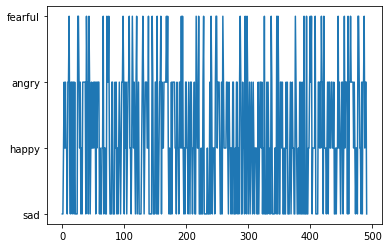

In [ ]:
import matplotlib.pyplot as plt
print(len(y_pred))
plt.plot(y_test)

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

array = confusion_matrix(y_test,y_pred)
print(array)

[[143   2   5   0]
 [  1  36   2  11]
 [  4   3 120   3]
 [  6   7   5 144]]
